In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
import seaborn as sns

%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)

In [2]:
df.outcome_type.value_counts()
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]
df = df[df['days_spent'] > 0]

In [3]:
c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'intake_type_clean', 'color_clean', 'intake_times', 'days_spent']]
c_data = c_data.dropna()

features_to_scale = c_data.copy()
features_to_scale = features_to_scale[['animal_age_in_days', 'days_spent']]

scaler = StandardScaler()
y = scaler.fit_transform(features_to_scale)


x = c_data.drop('days_spent', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = y[:, 1]

<AxesSubplot:ylabel='Count'>

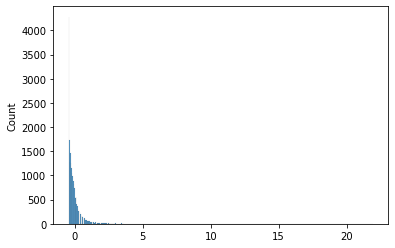

In [4]:
sns.histplot(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99)

In [6]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print('Coefficients: \n', lr.coef_)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_lr))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_lr))

Coefficients: 
 [ 0.05461778 -0.00089952  0.14730066 -0.16219493  0.02788927  0.00648546
 -0.01518169  0.00820775 -0.10807515]
Mean squared error: 0.96
Coefficient of determination: 0.02


In [7]:
params = {'n_estimators': 200,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls',
           'random_state': 0}

gbr = GradientBoostingRegressor(**params).fit(x_train, y_train)
y_pred_gbr = gbr.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_gbr))

Mean squared error: 0.72


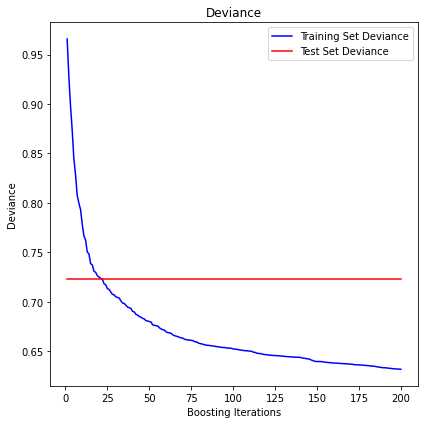

In [8]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(x_test)):
    test_score[i] = gbr.loss_(y_test, y_pred_gbr)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

<AxesSubplot:xlabel='days_spent', ylabel='Density'>

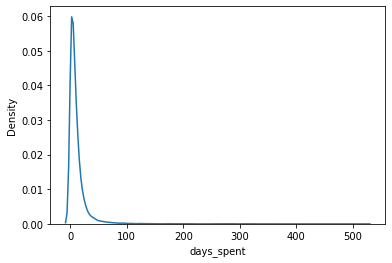

In [9]:
sns.kdeplot(df.days_spent)

In [10]:
print(df.days_spent.min())
print(df.days_spent.max())
print(df.days_spent.mean())
print(df.days_spent.median())
print(df.days_spent.std())

1
521
11.712066687924201
6.0
23.212324263224737


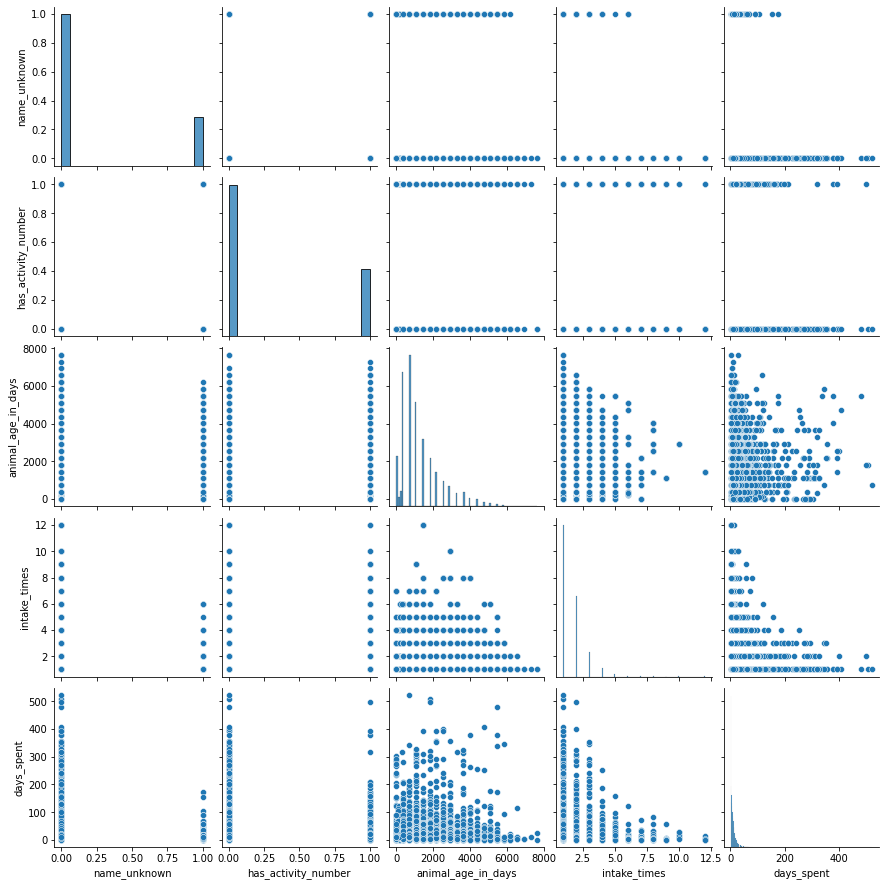

In [11]:
sns.pairplot(c_data)